## **Setup**

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

# **Build the encoder**

In [ ]:
latent_dim = 32

encoder_inputs = keras.Input(shape=(224, 224, 3))
x = layers.Conv2D(96, 11, 4, activation='relu')(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(256, 5, 1, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(384, 3, 1, activation='relu')(x)
x = layers.Conv2D(384, 3, 1, activation='relu')(x)
x = layers.Conv2D(256, 3, 1, activation='relu')(x)
x = layers.MaxPooling2D(3, 2)(x)
x = layers.Flatten()(x)

x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)


z = layers.Dense(latent_dim, name="z")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 54, 54, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 23, 23, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 23, 23, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 9, 9, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 7, 7, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 5, 5, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ z (Dense)                            │ (None, 32)                  │         131,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,078,112 (30.82 MB)

 Trainable params: 8,077,408 (30.81 MB)

 Non-trainable params: 704 (2.75 KB)

# **Build the decoder**

In [ ]:
decoder_inputs = keras.Input(shape=(latent_dim,))


x = layers.Dense(4096, activation='relu')(decoder_inputs)
x = layers.Dropout(0.5)(x)

x = layers.Dense(7 * 7 * 256, activation='relu')(x)
x = layers.Reshape((7, 7, 256))(x)

x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(384, 3, strides=1, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(384, 3, strides=1, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(256, 5, strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(96, 11, strides=4, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)


decoder_outputs = layers.Conv2DTranspose(3, 3, strides=2, padding='same', activation='sigmoid')(x)  # Upsample to 224x224

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4096)                │         135,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 12544)               │      51,392,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_18                  │ (None, 14, 14, 256)         │         590,080 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_19                  │ (None, 14, 14, 384)         │         885,120 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 14, 14, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_20                  │ (None, 14, 14, 384)         │       1,327,488 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 14, 14, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_21                  │ (None, 28, 28, 256)         │       2,457,856 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_22                  │ (None, 112, 112, 96)        │       2,973,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 112, 112, 96)        │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_23                  │ (None, 224, 224, 3)         │           2,595 │
│ (Conv2DTranspose)                    │                             │              

 Total params: 59,770,371 (228.01 MB)

 Trainable params: 59,767,619 (228.00 MB)

 Non-trainable params: 2,752 (10.75 KB)

# **Define the AE as a Model with a custom train_step**

In [ ]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        #self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Compute Mean Squared Error (MSE) loss per pixel
            mse_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
            per_pixel_loss = mse_loss(data, reconstruction)

            # Sum over spatial dimensions (height, width, and channels)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(per_pixel_loss, axis=[1, 2])  # Sum over height & width, averaging over channels
            )


            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),
        }

# **Load Dataset from kaggle**

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/GenAI_Assign_1/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download arpitjain007/dog-vs-cat-fastai



cp: cannot stat '/content/drive/MyDrive/GenAI_Assign_1/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/arpitjain007/dog-vs-cat-fastai
License(s): unknown
100% 1.59G/1.60G [00:20<00:00, 123MB/s]
100% 1.60G/1.60G [00:20<00:00, 82.0MB/s]


In [ ]:
!unzip /content/dog-vs-cat-fastai.zip

Streaming output truncated to the last 5000 lines.
  inflating: dogscats/train/dogs/dog.7066.jpg  
  inflating: dogscats/train/dogs/dog.7067.jpg  
  inflating: dogscats/train/dogs/dog.7068.jpg  
  inflating: dogscats/train/dogs/dog.7069.jpg  
  inflating: dogscats/train/dogs/dog.707.jpg  
  inflating: dogscats/train/dogs/dog.7070.jpg  
  inflating: dogscats/train/dogs/dog.7071.jpg  
  inflating: dogscats/train/dogs/dog.7072.jpg  
  inflating: dogscats/train/dogs/dog.7073.jpg  
  inflating: dogscats/train/dogs/dog.7074.jpg  
  inflating: dogscats/train/dogs/dog.7075.jpg  
  inflating: dogscats/train/dogs/dog.7076.jpg  
  inflating: dogscats/train/dogs/dog.7077.jpg  
  inflating: dogscats/train/dogs/dog.7078.jpg  
  inflating: dogscats/train/dogs/dog.7079.jpg  
  inflating: dogscats/train/dogs/dog.708.jpg  
  inflating: dogscats/train/dogs/dog.7080.jpg  
  inflating: dogscats/train/dogs/dog.7081.jpg  
  inflating: dogscats/train/dogs/dog.7082.jpg  
  inflating: dogscats/train/dogs/dog.70

# **Train the AE**

In [ ]:
import tensorflow as tf
import numpy as np

# Define dataset paths
train_dir = "/content/dogscats/dogscats/train"  # Update this path
val_dir = "/content/dogscats/dogscats/valid"

# Load training dataset (RGB, keeps class structure)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # Resize to match the VAE input shape
    batch_size=128,
    shuffle=True
)

# Load validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=128,
    shuffle=True
)

def normalize(image, label):  # Accept both image and label
    image = tf.cast(image, tf.float32) / 255.0  # Normalize image
    return image  # Ignore the label

# Apply normalization to both datasets
train_dataset = train_dataset.map(normalize)
val_dataset = val_dataset.map(normalize)




Found 23000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
ae = AE(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam())
history = ae.fit(train_dataset, epochs=25, batch_size=128)

Epoch 1/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 144s 721ms/step - loss: 3537.8933 - reconstruction_loss: 3537.8933
Epoch 2/25
 86/180 ━━━━━━━━━━━━━━━━━━━━ 1:06 707ms/step - loss: 3309.6326 - reconstruction_loss: 3309.6326

In [ ]:
ae.build(input_shape=(None, 224, 224, 3))
ae.save_weights("/content/ae2_14L.weights.h5")
!mv "/content/ae2_14L.weights.h5" /content/drive/MyDrive/



# **Display**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to your test images
image_dir = "/content/dogscats/test1"
image_size = (224, 224)  # Match model input size
num_samples = 25  # Number of images to load

# Get image filenames
image_files = sorted(os.listdir(image_dir))[:num_samples]  # Load first 'num_samples' images

# Load and resize images
sample_images = []
for img_name in image_files:
    img_path = os.path.join(image_dir, img_name)
    img = load_img(img_path, target_size=image_size)  # Resize to (224,224)
    img = img_to_array(img) / 255.0  # Normalize to [0,1]
    sample_images.append(img)

# Convert list to numpy array
sample_images = np.array(sample_images)

print(f"Loaded {sample_images.shape[0]} images of shape {sample_images.shape[1:]}")


Loaded 25 images of shape (224, 224, 3)


In [ ]:
# Pass images through the autoencoder
encoded_images = ae.encoder.predict(sample_images, verbose=0)
decoded_images = ae.decoder.predict(encoded_images, verbose=0)


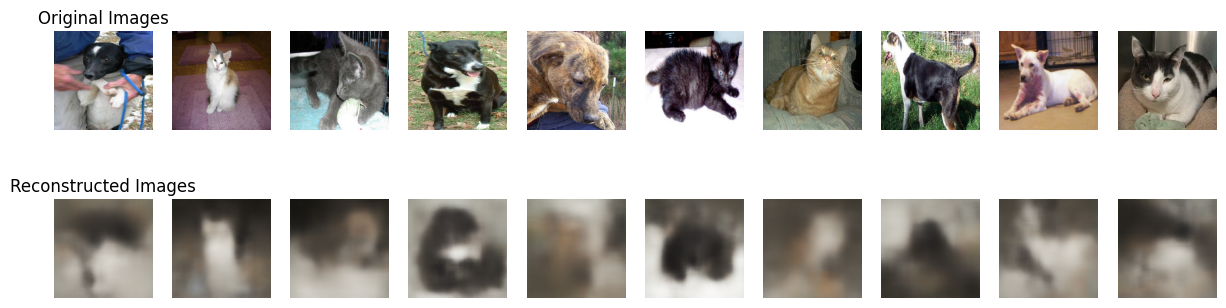

In [ ]:
# Plot original vs reconstructed images
n = min(num_samples, 10)  # Show up to 10 images
fig, axes = plt.subplots(2, n, figsize=(15, 4))

for i in range(n):
    # Original Image
    axes[0, i].imshow(sample_images[i])
    axes[0, i].axis("off")

    # Reconstructed Image
    axes[1, i].imshow(decoded_images[i])
    axes[1, i].axis("off")

axes[0, 0].set_title("Original Images")
axes[1, 0].set_title("Reconstructed Images")
plt.show()


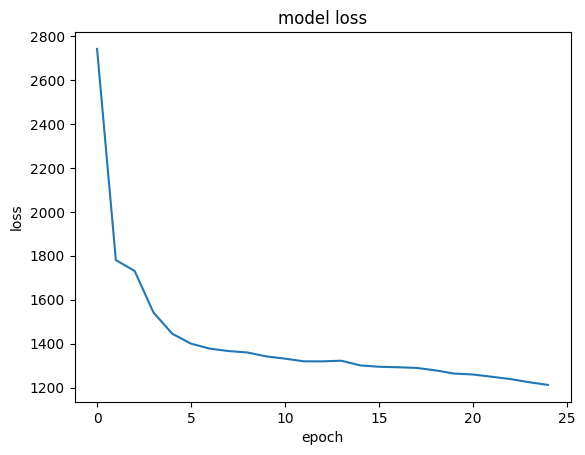

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['reconstruction_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# Compute Mean Squared Error (MSE)
mse = np.mean(np.square(sample_images - decoded_images))
print(f"Reconstruction MSE: {mse:.6f}")


Reconstruction MSE: 0.029924


In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)